### Loan Approval Prediction 
The existing manual evaluation of loan applications is time-consuming andprone to human bias, leading to inconsistent outcomes and increased risks.The problem at hand is to develop an accurate loan approval predictionsystem that can effectively assess the creditworthiness of loan applicants.
Here's a Machine Learning model that predicts whether or not the loanshould be approved for the applicant taking into consideration variousfactors such as applicant income, gender, marital status, credit history etc.

In [1]:
# Importing the required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats   
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,\
recall_score,f1_score,cohen_kappa_score,classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")


from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing the train and test datasets

train = pd.read_csv(r'train_ctrUa4K.csv')
test = pd.read_csv(r'test_lAUu6dG.csv')

In [3]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [5]:
# Shape of the data
train.shape, test.shape

((614, 13), (367, 12))

In [6]:
# Combining the train and test datasets

combined = pd.concat([train,test],ignore_index=True)
combined.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
combined.shape

(981, 13)

In [8]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 99.8+ KB


In [9]:
combined.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


### Univariate Analysis

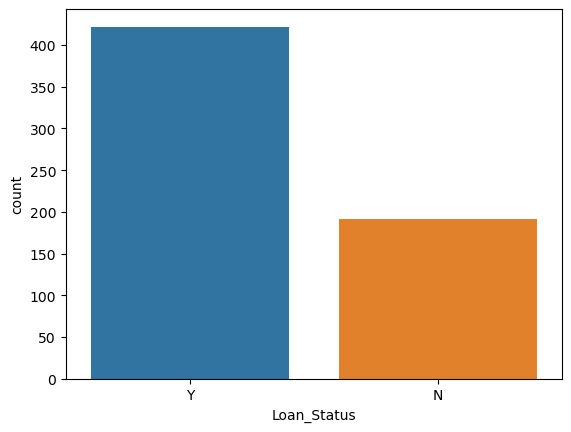

In [10]:
# Plotting the target variable
sns.countplot(combined.Loan_Status)
plt.show()

* The target variable is imbalanced.

#### Separating the numerical and categorical columns

In [11]:
combined.select_dtypes(include = np.number).columns


Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [12]:
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [13]:
combined.select_dtypes('object').columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [14]:
cat_cols = [ 'Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'Property_Area',\
            'Loan_Amount_Term', 'Credit_History']

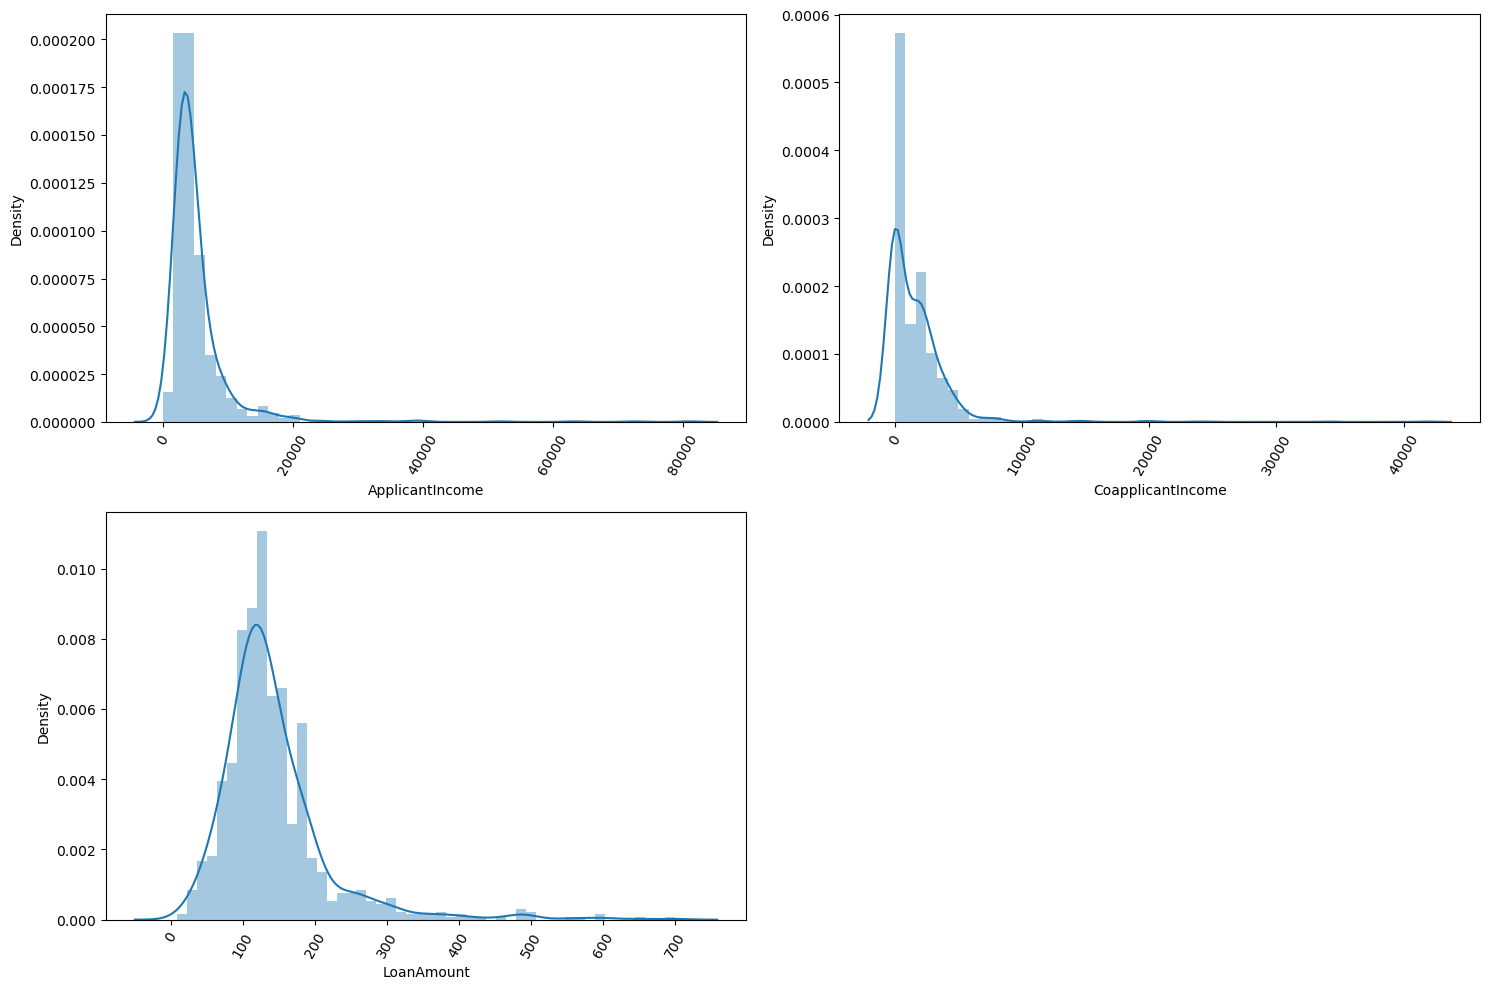

In [15]:
# Plotting the numerical columns

nrows = 2
ncols = 2
repeater = 1
plt.figure(figsize=(15,10))
for i in num_cols:
    plt.subplot(nrows,ncols,repeater)
    sns.distplot(combined.loc[:,i])
    plt.xticks(rotation = 60)
    repeater += 1
plt.tight_layout()
plt.show()

* Both Applicant and co-applicant income are highly positively skewed.
* Loan amount is also positively skewed
* The variables Loan amount term and credit history are categorical.

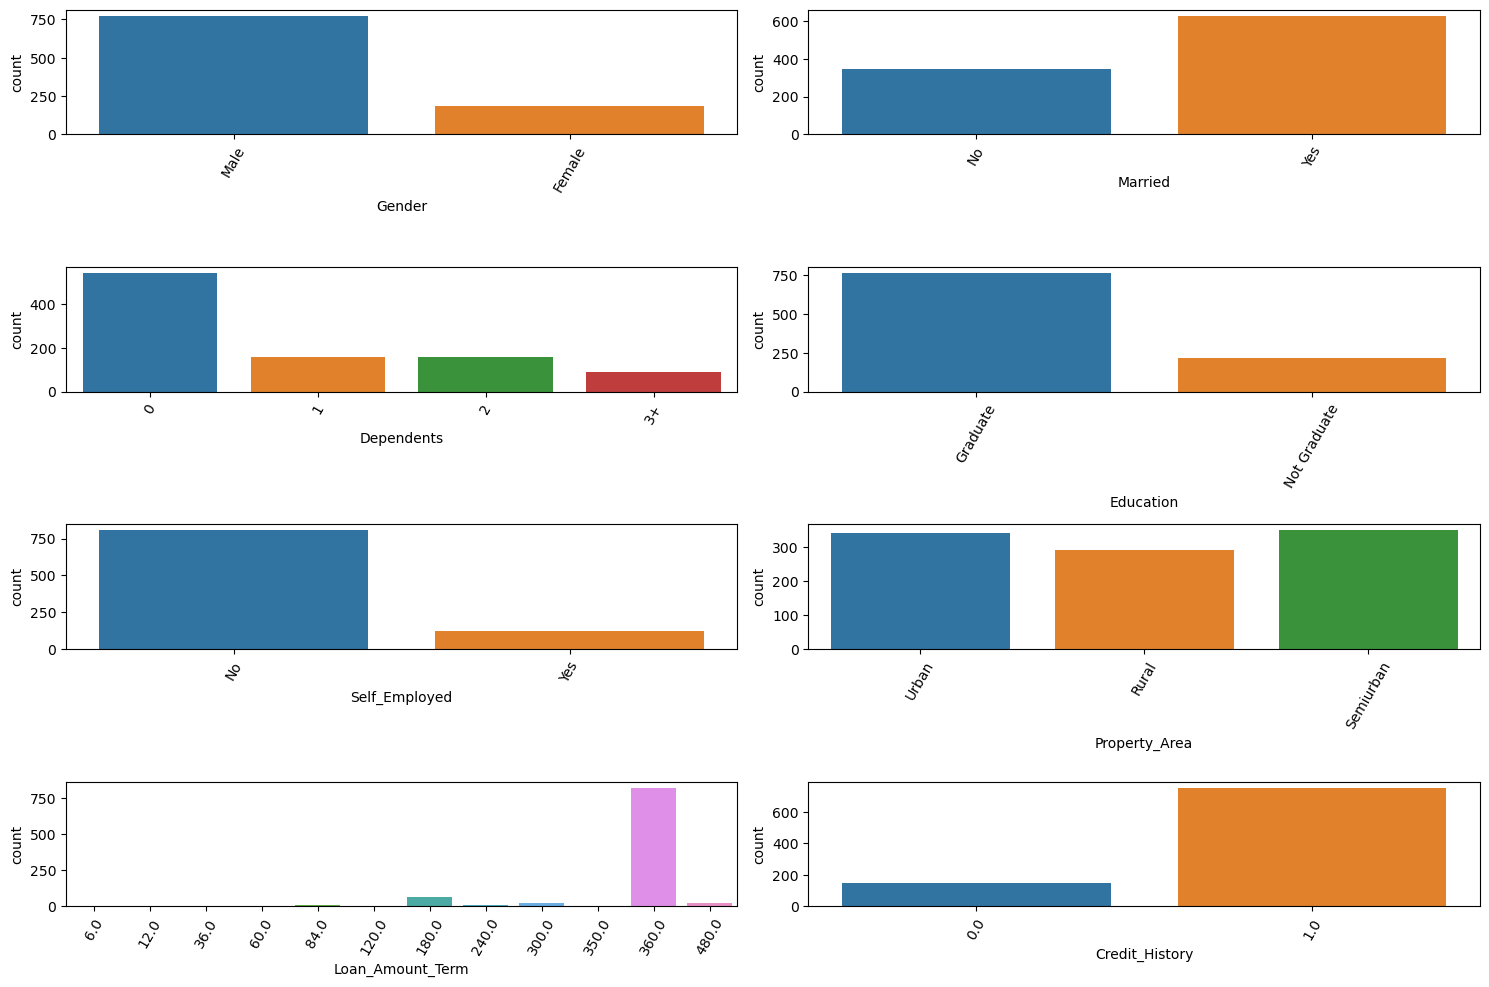

In [16]:
# Plotting the categorical columns

nrows = 4
ncols = 2
repeater = 1
plt.figure(figsize=(15,10))
for i in cat_cols:
    plt.subplot(nrows,ncols,repeater)
    sns.countplot(combined.loc[:,i])
    plt.xticks(rotation = 60)
    repeater += 1
plt.tight_layout()
plt.show()

* There are more male applicants as compared to female applicants
* Most applicants are married, graduate and salaried.
* The term of the loan is likely to be 360 months.

## Bivariate Analysis

#### All Columns V/S Loan Status

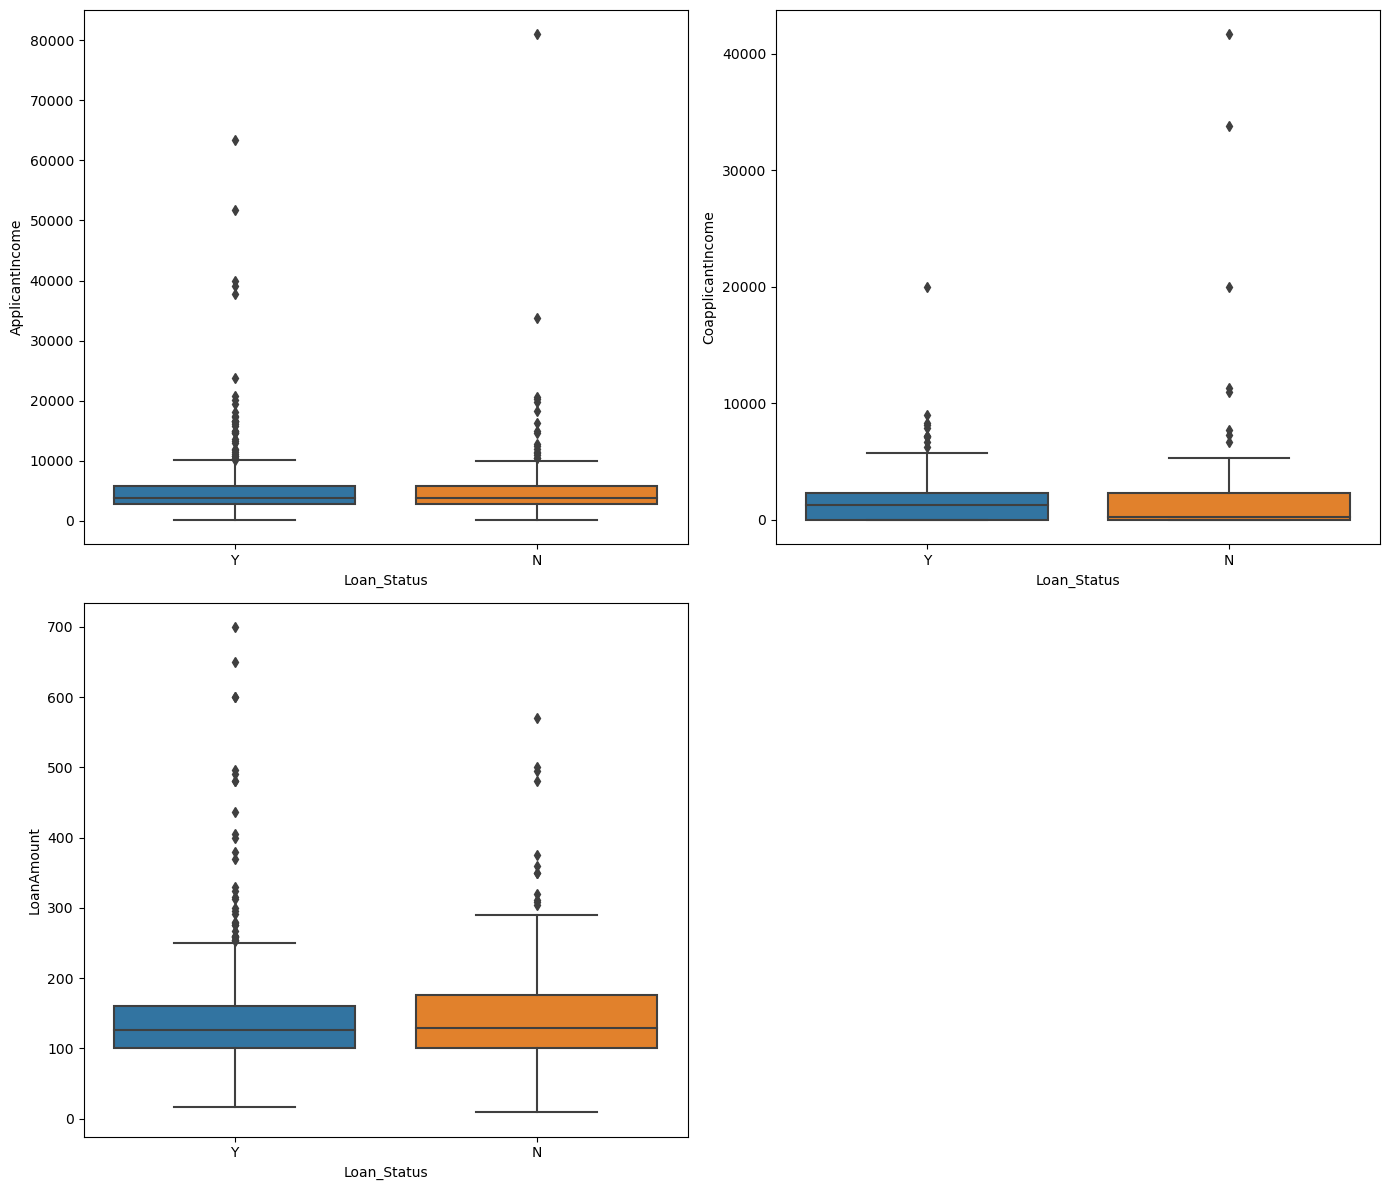

In [17]:
nrows = 2
ncols = 2
iterator = 1
plt.figure(figsize = (14, 12))

for i in num_cols:
    plt.subplot(nrows, ncols, iterator)
    sns.boxplot(combined.loc[:, "Loan_Status"],
                combined.loc[:, i])
    iterator+=1
    
plt.tight_layout()
plt.show()

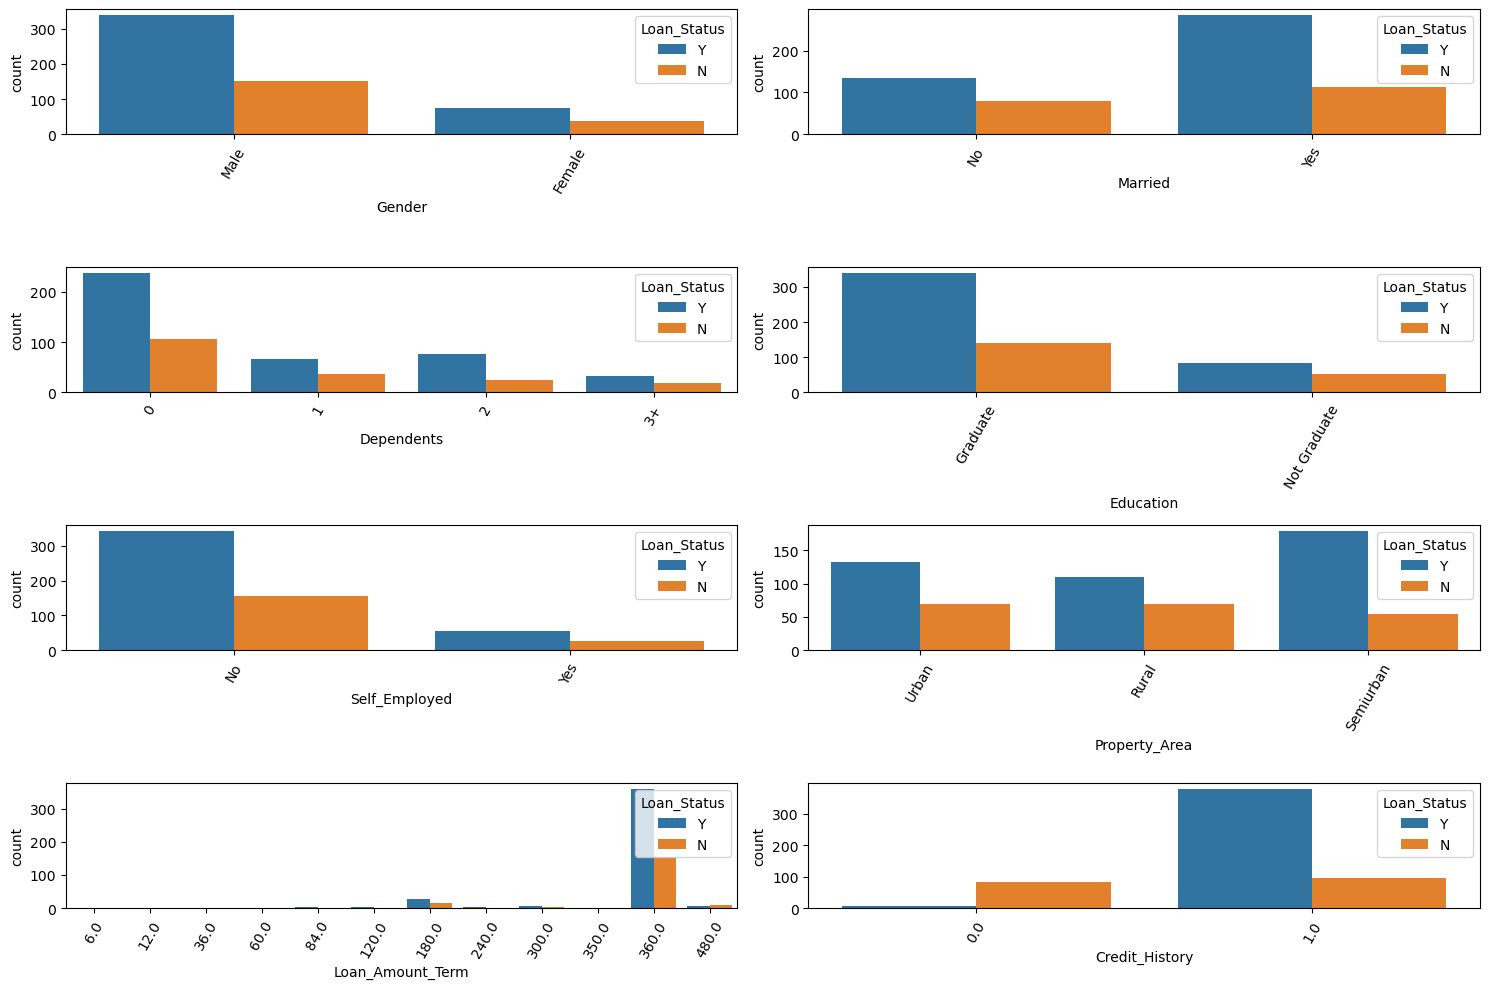

In [18]:
# Plotting the categorical columns

nrows = 4
ncols = 2
repeater = 1
plt.figure(figsize=(15,10))
for i in cat_cols:
    plt.subplot(nrows,ncols,repeater)
    sns.countplot(combined[i],hue=combined['Loan_Status'])
    plt.xticks(rotation = 60)
    repeater += 1
plt.tight_layout()
plt.show()

In [19]:
combined.Loan_Amount_Term = combined.Loan_Amount_Term.astype('object')
combined.Credit_History = combined.Credit_History.astype('object')

## Missing Values

In [20]:
combined.isnull().sum()[combined.isnull().sum()!=0]

Gender               24
Married               3
Dependents           25
Self_Employed        55
LoanAmount           27
Loan_Amount_Term     20
Credit_History       79
Loan_Status         367
dtype: int64

In [21]:
combined[combined.Gender.isnull()].head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
126,LP001448,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
171,LP001585,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
188,LP001644,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,Y
314,LP002024,NaN,Yes,0,Graduate,No,2473,1843.0,159.0,360.0,1.0,Rural,N


In [22]:
combined.Gender.fillna(combined.Gender.mode()[0], inplace=True)
combined.Married.fillna(combined.Married.mode()[0], inplace=True)
combined.Dependents.fillna(combined.Dependents.mode()[0], inplace=True)
combined.Self_Employed.fillna(combined.Self_Employed.mode()[0], inplace=True)
combined.Credit_History.fillna(combined.Credit_History.mode()[0],inplace=True)
combined.LoanAmount.fillna(combined.LoanAmount.median(), inplace=True)
combined.Loan_Amount_Term.fillna(combined.Loan_Amount_Term.median(), inplace=True)

In [23]:
combined.isnull().sum()

Loan_ID                0
Gender                 0
Married                0
Dependents             0
Education              0
Self_Employed          0
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount             0
Loan_Amount_Term       0
Credit_History         0
Property_Area          0
Loan_Status          367
dtype: int64

In [24]:
q1 = combined.quantile(0.25)
q3 = combined.quantile(0.75)
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
combined.loc[~((combined<ll)|(combined>ul)).any(axis=1)].shape

(618, 13)

* We will not be removing the outliers from the data due to lack of enough rows in the data

### Feature Engineering

In [25]:
combined.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,126.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [26]:
combined['Total_Income'] = combined['ApplicantIncome'] + combined['CoapplicantIncome']

In [27]:
def dep(x):
    if x == '0':
        return 0
    else:
        return 1

In [28]:
combined['Dependents'] = combined['Dependents'].apply(dep)

In [29]:
combined.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome'],axis = 1, inplace=True)

In [30]:
combined = pd.get_dummies(combined, drop_first=True)
combined.head()

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,0,126.0,360.0,1.0,5849.0,1,0,0,0,0,1,1
1,1,128.0,360.0,1.0,6091.0,1,1,0,0,0,0,0
2,0,66.0,360.0,1.0,3000.0,1,1,0,1,0,1,1
3,0,120.0,360.0,1.0,4941.0,1,1,1,0,0,1,1
4,0,141.0,360.0,1.0,6000.0,1,0,0,0,0,1,1


In [31]:
# Splitting the data back to train and test
newtrain = combined.loc[:len(train)-1,:]
newtest = combined.loc[len(train):,:]
newtrain.shape, newtest.shape

((614, 12), (367, 12))

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X = newtrain.drop('Loan_Status_Y', axis=1)
y = newtrain['Loan_Status_Y']
newtest = newtest.drop('Loan_Status_Y', axis=1)

In [34]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2, random_state=42)

In [35]:
def base_models():
    models = dict()
    models["lg"] = LogisticRegression()
    models["tree"] = DecisionTreeClassifier(criterion="entropy")
    models["RF"] = RandomForestClassifier(criterion="entropy")
    models["Adaboost"] = AdaBoostClassifier()
    models["GBM"] = GradientBoostingClassifier()
    models["XGB"] = XGBClassifier()
    models["LGBM"] = LGBMClassifier()
    models["cboost"] = CatBoostClassifier()
    return models

In [36]:
def eval_scores(model):
    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
    scores = cross_val_score(model, X, y, scoring = "roc_auc", cv = cv,
                   error_score="raise", n_jobs=-1)
    return scores

In [37]:
models = base_models()

result, names = list(), list()

for name, model in models.items():
    finalscore = eval_scores(model)
    result.append(finalscore)
    names.append(name)
    print((name, np.mean(result)), np.std(result))

('lg', 0.762721263944174) 0.03937548856123234
('tree', 0.7188420050881351) 0.05821166215942294
('RF', 0.7295040233817324) 0.050618494874259734
('Adaboost', 0.7270006062478973) 0.047538538653979306
('GBM', 0.7263245992054042) 0.043319717801882957
('XGB', 0.7285815453036815) 0.04087573000878366
('LGBM', 0.7294485689012447) 0.03865024432959147
('cboost', 0.7306450149222983) 0.03745369962131579


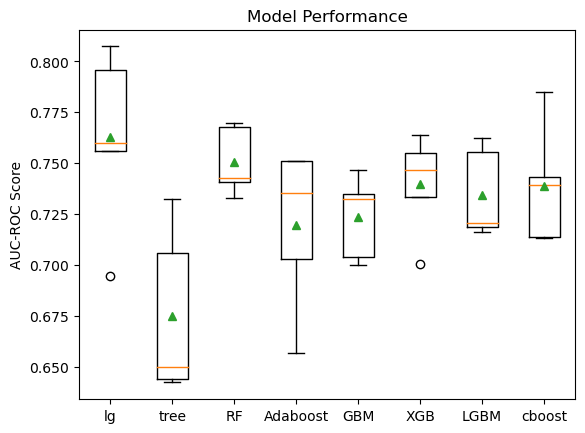

In [38]:
# Visualize the Scores
plt.boxplot(result, labels = names, showmeans=True)
plt.title("Model Performance")
plt.ylabel("AUC-ROC Score")
plt.show()

In [41]:
# Balancing the target variable

ros = RandomOverSampler(random_state=42)
x_samp, y_samp = ros.fit_resample(X,y)
x_samp.shape, y_samp.shape

((844, 11), (844,))

In [42]:
y_samp.value_counts()

1    422
0    422
Name: Loan_Status_Y, dtype: int64

In [43]:
Xtrain_samp, Xtest_samp, ytrain_samp, ytest_samp = train_test_split(x_samp,y_samp,test_size=0.2,random_state=42)

In [44]:
def eval_scores_samp(model):
    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
    scores = cross_val_score(model,x_samp, y_samp, scoring = "roc_auc", cv = cv,error_score="raise", n_jobs=-1)
    return scores

In [45]:
models = base_models()

result, names = list(), list()

for name, model in models.items():
    finalscore = eval_scores_samp(model)
    result.append(finalscore)
    names.append(name)
    print((name, np.mean(result)), np.std(result))

('lg', 0.8062555022008804) 0.03192685158279433
('tree', 0.821923269307723) 0.028792312470803237
('RF', 0.8621842625939263) 0.06286439440244479
('Adaboost', 0.8540751300520208) 0.058248874850399375
('GBM', 0.8579630852340937) 0.054023188579147924
('XGB', 0.8666231770485971) 0.05411756945279498
('LGBM', 0.8732026858362393) 0.05376859044206398
('cboost', 0.8755534088635454) 0.05203587940336427


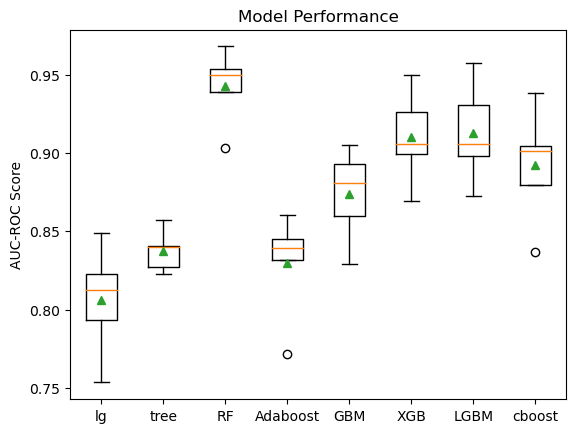

In [47]:
# Visualize the Scores
plt.boxplot(result, labels = names, showmeans=True)
plt.title("Model Performance")
plt.ylabel("AUC-ROC Score")
plt.show()

* Models started performing better after the data is balanced.